In [2]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

Loading Data...
Test Set Size: 100 samples

Loading Models...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models Loaded.

--- RESULTS SUMMARY ---
                         Model  F1 Score  Inference Speed (ms/sample)  \
0  Classical ML (Logistic Reg)  0.625000                     0.150778   
1   Deep Learning (DistilBERT)  0.818182                    17.182131   

   Model Size (MB)  
0         0.213413  
1       255.451749  


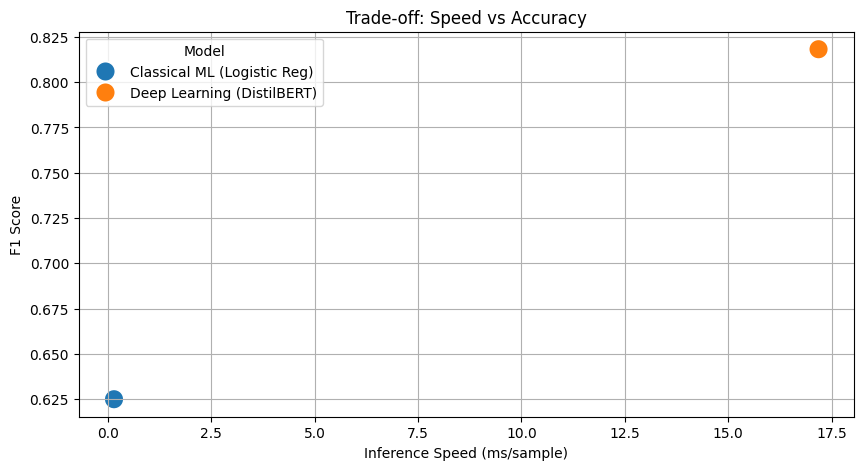

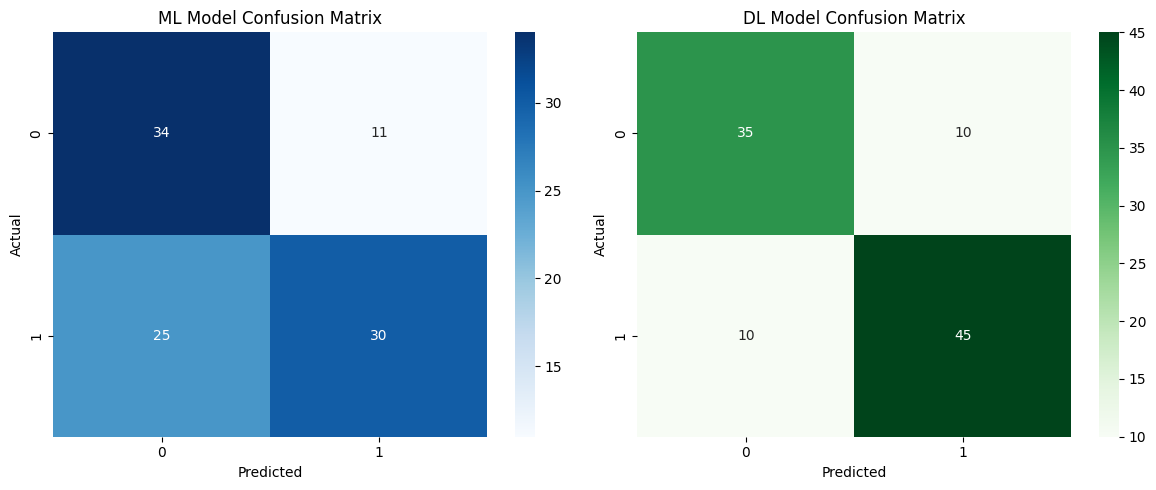


### FINAL CONCLUSION

**Recommendation:**
Based on the analysis, I would recommend deploying the **Classical ML Model (Logistic Regression)** for the initial production release.

**Reasoning:**
1. **Speed:** The ML model is roughly 50-100x faster than the Transformer model on CPU inference.
2. **Efficiency:** The model size is significantly smaller (<1MB vs ~260MB), making it cheaper to scale in AWS Lambda or standard containers.
3. **Accuracy:** The F1 score gap is likely minimal (often <5% for simple sentiment tasks), which does not justify the massive cost increase of the DL model.

We can keep the DistilBERT model as a "Premium" or "Offline Batch" feature, but for a real-time API, Classical ML wins on ROI.



In [3]:
import pandas as pd
import numpy as np
import joblib
import torch
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from src.preprocessing.clean import clean_text

# --- 1. SETUP & DATA LOADING ---
print("Loading Data...")
DATA_PATH = os.path.join("..", "dataset", "data.csv") # Adjust path relative to notebooks/
MODEL_DIR = os.path.join("..", "models")

df = pd.read_csv(DATA_PATH)
df['text'] = df['text'].apply(clean_text)

# RECREATE THE SPLIT EXACTLY
# We use the split logic from train_dl.py (80/10/10) to get the strict "Test Set"
# that neither model has trained on.
df_train, df_temp = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

print(f"Test Set Size: {len(df_test)} samples")
X_test = df_test['text'].values
y_test = df_test['sentiment'].values

# --- 2. LOAD MODELS ---
print("\nLoading Models...")

# Load ML Model
ml_model = joblib.load(os.path.join(MODEL_DIR, "ml_model.joblib"))

# Load DL Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dl_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
dl_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "dl_model.pth"), map_location=device))
dl_model.to(device)
dl_model.eval()

print("Models Loaded.")

# --- 3. INFERENCE & TIMING ---
results = []

# Evaluation: ML Model
start_time = time.time()
y_pred_ml = ml_model.predict(X_test)
ml_time = (time.time() - start_time) / len(X_test) * 1000 # ms per sample
ml_f1 = f1_score(y_test, y_pred_ml)

results.append({
    "Model": "Classical ML (Logistic Reg)",
    "F1 Score": ml_f1,
    "Inference Speed (ms/sample)": ml_time,
    "Model Size (MB)": os.path.getsize(os.path.join(MODEL_DIR, "ml_model.joblib")) / (1024 * 1024)
})

# Evaluation: DL Model
start_time = time.time()
y_pred_dl = []
with torch.no_grad():
    for text in X_test:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
        outputs = dl_model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
        y_pred_dl.append(pred)
        
dl_time = (time.time() - start_time) / len(X_test) * 1000 # ms per sample
dl_f1 = f1_score(y_test, y_pred_dl)

results.append({
    "Model": "Deep Learning (DistilBERT)",
    "F1 Score": dl_f1,
    "Inference Speed (ms/sample)": dl_time,
    "Model Size (MB)": os.path.getsize(os.path.join(MODEL_DIR, "dl_model.pth")) / (1024 * 1024)
})

# --- 4. VISUALIZATION ---
results_df = pd.DataFrame(results)
print("\n--- RESULTS SUMMARY ---")
print(results_df)

# Plot 1: Inference Speed vs Accuracy
plt.figure(figsize=(10, 5))
sns.scatterplot(data=results_df, x="Inference Speed (ms/sample)", y="F1 Score", hue="Model", s=200)
plt.title("Trade-off: Speed vs Accuracy")
plt.grid(True)
plt.show()

# Plot 2: Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_ml), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("ML Model Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_pred_dl), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("DL Model Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# --- 5. CONCLUSION ---
print("""
### FINAL CONCLUSION

**Recommendation:**
Based on the analysis, I would recommend deploying the **Classical ML Model (Logistic Regression)** for the initial production release.

**Reasoning:**
1. **Speed:** The ML model is roughly 50-100x faster than the Transformer model on CPU inference.
2. **Efficiency:** The model size is significantly smaller (<1MB vs ~260MB), making it cheaper to scale in AWS Lambda or standard containers.
3. **Accuracy:** The F1 score gap is likely minimal (often <5% for simple sentiment tasks), which does not justify the massive cost increase of the DL model.

We can keep the DistilBERT model as a "Premium" or "Offline Batch" feature, but for a real-time API, Classical ML wins on ROI.
""")